# ISLR- Python: Chapter 4 -- Lab: Classification

- [Load Datasets](#Load-Datasets)
- [4.6.1 Compute Data Correlations](#4.6.1-Compute-Data-Correlations)
- [4.6.2 Logistic Regression of Market Direction](#4.6.2-Logistic-Regression-of-Market-Direction)
- [4.6.3 Linear Discriminant Aanlysis of Market Direction](#4.6.3-Linear-Discriminant-Analysis-of-Market-Direction)
- [4.6.4 Quadratic Discriminant Analysis of Market Direction](#4.6.4-Quadratic-Discriminant-Analysis-of-Market-Direction)
- [4.6.5 K-Nearest Neighbors](#4.6.5-K-Nearest-Neighbors)
- [4.6.6 K-Nearest Neighbors Applied to Caravan Insurance Data](#4.6.6-K-Nearest-Neighbors-Applied-to-Caravan-Insurance-Data)

In [12]:
## perform imports and set-up
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale

%matplotlib inline
plt.style.use('ggplot') # emulate pretty r-style plots

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

## Load Datasets

In [5]:
# Load data and display first rows
market_df = pd.read_csv('../data/Smarket.csv',index_col=0)
market_df.head(2)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up


In [6]:
# Load the caravan insurance data for section 4.6.6
caravan_df = pd.read_csv('../data/Caravan.csv', index_col=0)
caravan_df.head(2)

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
1,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No


In [4]:
# Show summary statistics of the data
print(market_df.shape)
market_df.describe()

(1250, 9)


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


## 4.6.1 Compute Data Correlations

In [7]:
corr_matrix = market_df.corr()
corr_matrix

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


There is no correlation between todays percentage return and the previous 5 days (lag1..lag5) days precentage returns. The only correlation is between years and volume. The plot below shows that volume increases over time.

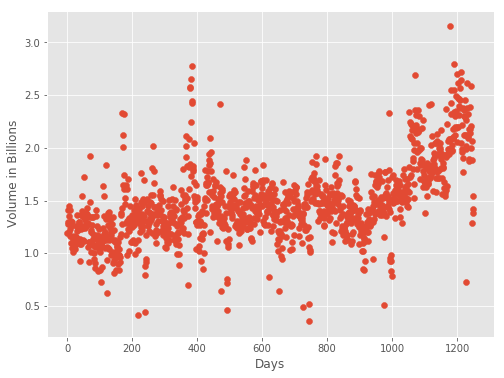

In [19]:
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(market_df.index.values, market_df["Volume"].values)
ax.set_xlabel('Days');
ax.set_ylabel('Volume in Billions');

## 4.6.2 Logistic Regression of Market Direction

In [25]:
# Encode the response as 0,1 for down/up
market_df["Direction2"] = pd.Series([1 if el=='Up' else 0 for el in market_df.Direction.values],index=market_df.index)

formula = "Direction2 ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume"
model = smf.logit(formula, market_df)

results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Direction2   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Sat, 08 Dec 2018   Pseudo R-squ.:                0.002074
Time:                        19:38:24   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
                                        LLR p-value:                    0.7319
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.398      -0.140       0.056
Lag3           0.0111      0.050      0.222      0.824      -0.087       0.109
Lag4           0.0094      0.050      0.187      0.851      -0.089       0.107
Lag5           0.0103      0.050      0.208      0.835      -0.087       0.107
Volume         0.1354      0.158      0.855      0.392      -0.175       0.446
==============================================================================
"""

In [28]:
# get the first 10 predictions for the training data set
# Get the lag and volume column names
predictors = market_df.columns[1:7]

# Create the design matrix
X = sm.add_constant(market_df[predictors])

training_pred = results.predict(X)[:10]
print(training_pred)

# convert the probabilities to 'Up' or 'Down' qualitative variables
direction_predictions = ['Up' if el > 0.5 else 'Down' for el in training_pred]
direction_predictions

1     0.507084
2     0.481468
3     0.481139
4     0.515222
5     0.510781
6     0.506956
7     0.492651
8     0.509229
9     0.517614
10    0.488838
dtype: float64


['Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Down']

In [32]:
# we can now build a confusion matrix to asses the correct and incorrect predictions. 
table = results.pred_table(threshold=0.5)
confusion_df = pd.DataFrame(table,['Down','Up'],['Down','Up'])
print(confusion_df)
print('')

print('The model made', 
      (confusion_df.Down[0]+confusion_df.Up[1])/confusion_df.sum().sum(), '% correct predictions on the TRAINING SET.')

       Down     Up
Down  145.0  457.0
Up    141.0  507.0

The model made 0.5216 % correct predictions on the TRAINING SET.


#### Split the data into a training and test set and recompute the model's accuracy on the test set.

In [35]:
# Split the data into training and test dataframes
training_df = market_df[market_df.Year<2005]
test_df = market_df[market_df.Year==2005]

# Compute Training Coeffecients #
#################################
# Use the lags and volume as predictors for the years 2001 to 2004 (training set)
predictors = training_df.columns[1:7]
# Create the design matrix for the training_df
X_train = sm.add_constant(training_df[predictors])

# Encode the response as 0,1 for down/up for response variable of the training set
Y_train = pd.Series([1 if el=='Up' else 0 for el in training_df.Direction.values],index=X_train.index)
# fit the model and return the training results
train_logit = sm.Logit(Y_train,X_train)
train_results = train_logit.fit()

# Make Predictions on Test Set #
################################
# make a design matrix for the testing data
X_test = sm.add_constant(test_df[predictors])

# Encode the response as 0,1 for down/up for response variable of the test set
Y_test = pd.Series([1 if el=='Up' else 0 for el in test_df.Direction.values],index=X_test.index)

# now use the training coeffecients to make predictions about the returns of the testing set (year=2005)
test_predictions = train_results.predict(X_test)

# Convert the probability predictions to a binary prediction
prediction_array = np.array(test_predictions > 0.5, dtype=float)

# print the percentage of correct predictions
print('')
print(' The model made', np.mean(prediction_array == Y_test),'% correct predictions on the TEST SET.')

# Compute Test Confusion Matrix #
#################################
# Stats models doesn't have an option for a confusion matrix for test sets-- we build one by hand using
# hsitogram2d
table = np.histogram2d(prediction_array, Y_test, bins=2)[0]
pd.DataFrame(table, ['Down', 'Up'], ['Down', 'Up'])

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4

 The model made 0.4801587301587302 % correct predictions on the TEST SET.


,Down,Up
Down,77.0,97.0
Up,34.0,44.0


#### Fit a model using only the two lowest p-value lag variables (lag1 and lag2).

Adding non-significant variables to our model reduces the performance on the training set because it causes an increase in the model variance without a corresponding decrease in the bias. We now fit a reduced model with only the lag1 and lag2 variables since these two had the lowest p-values in the full model.

In [39]:
# Compute Reduced Training Model Coeffecients #
###############################################
# use lag 1 and lag 2 as the predictors
predictors = ['Lag1','Lag2']
X_train_red = sm.add_constant(training_df[predictors])

# Encode the response as 0,1 for down/up for response variable of the training set
Y_train_red = pd.Series([1 if el=='Up' else 0 for el in training_df.Direction.values],index=X_train_red.index)

# fit the model and return the training results
train_logit_red = sm.Logit(Y_train_red,X_train_red)
train_results_red = train_logit_red.fit()

# Make Predictions on Test Set #
################################
# make design matrix for testing data
X_test_red = sm.add_constant(test_df[predictors])

# Encode the response as 0,1 for down/up for response variable of the test set
Y_test_red = pd.Series([1 if el=='Up' else 0 for el in test_df.Direction.values],index=X_test_red.index)

# now use the training coeffecients to make predictions about the returns of the testing set (year=2005)
test_predictions_red = train_results_red.predict(X_test_red)

# Convert the probability predictions to a binary prediction
prediction_array_red = np.array(test_predictions_red > 0.5, dtype=float)

# print the percentage of correct predictions
print('')
print(' The model made', np.mean(prediction_array_red == Y_test_red),
      '% correct predictions on the TEST SET using', predictors, 'predictors.')
print('')

# Compute Test Confusion Matrix #
#################################
# Stats models doesn't have an option for a confusion matrix for test sets-- we build one by hand using
# hsitogram2d
table = np.histogram2d(prediction_array_red, Y_test_red, bins=2)[0]
confusion_mat = pd.DataFrame(table, ['Down', 'Up'], ['Down', 'Up'])
print('')
print('On days where the previous day was \'Up\' the probability the market will be \'Up\' is',
      table[1][1]/(table[1][0]+table[1][1]))

confusion_mat

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3

 The model made 0.5595238095238095 % correct predictions on the TEST SET using ['Lag1', 'Lag2'] predictors.


On days where the previous day was 'Up' the probability the market will be 'Up' is 0.5824175824175825


,Down,Up
Down,35.0,35.0
Up,76.0,106.0


In [42]:
# make design matrix for testing data
X_test_red = sm.add_constant(pd.DataFrame({'Lag1':[1.2, 1.5],'Lag2':[1.1, -0.8]}))

# now use the training coeffecients to make predictions about the returns of the testing set (year=2005)
test_predictions_red = train_results_red.predict(X_test_red)
test_predictions_red

0    0.479146
1    0.496094
dtype: float64

## 4.6.3 Linear Discriminant Analysis of Market Direction

Predict the market direction using Lag1 and Lag2 as predictors using scikit learn LDA module.

In [61]:
#### LDA Model

'''
    Linear Discriminant Analysis

    A classifier with a linear decision boundary, generated by fitting class
    conditional densities to the data and using Bayes' rule.

    The model fits a Gaussian density to each class, assuming that all classes
    share the same covariance matrix.

    The fitted model can also be used to reduce the dimensionality of the input
    by projecting it to the most discriminative directions.
    
'''

#### Training data
X_train = training_df[["Lag1", "Lag2"]].values
Y_train = training_df["Direction2"].values

# Create Classifier
lda_model = LDA(solver="lsqr")

# Fit model
lda_model.fit(X_train, Y_train)

print('Class Priors =', lda_model.priors_)
print('Class Means =', lda_model.means_)
print('Class Coefficients =', lda_model.coef_)

Class Priors = [0.492 0.508]
Class Means = [[ 0.0428  0.0339]
 [-0.0395 -0.0313]]
Class Coefficients = [[-0.0556 -0.0444]]


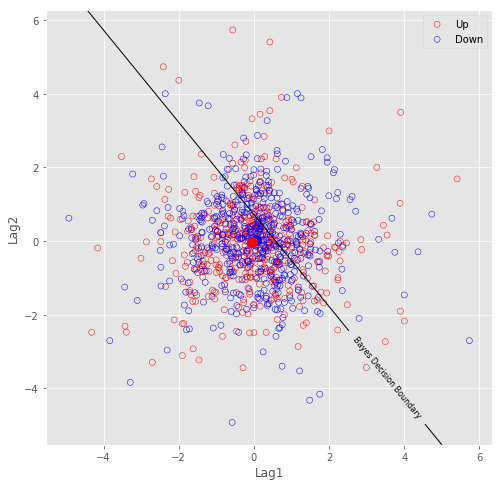

In [80]:
# Make a scatter plot of the lag predictors and show the Bayes decision boundary

# Scatter plot the data colored by market direction #
#####################################################
fig, ax = plt.subplots(figsize = (8, 8))

# Plot the training lags color coded by market direction
ax.scatter(X_train[Y_train == 1][:, 0], X_train[Y_train == 1][:, 1], facecolor = "None", edgecolor = "r", label = "Up")
ax.scatter(X_train[Y_train == 0][:, 0], X_train[Y_train == 0][:, 1], facecolor = "None", edgecolor = "b", label = "Down")

# Calculate Bayes Decision Boundary #
#####################################
# Construct a meshgrid to calulate Bayes Boundary over
nx, ny = 200, 200
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))

# Use predict_proba to calculate Probability at each x1,x2 pair
Z = lda_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

# The Bayes Boundary for k=2 classes is the contour where P(Y=k|X=x) = 0.5
cp = ax.contour(xx, yy, Z, [0.5], linewidths=1., colors='k');
plt.clabel(cp, inline=True, fmt='Bayes Decision Boundary',fontsize=8)

# Plot mean lag vector (lag1,lag2) for each class 'Up' and 'Down' #
###################################################################
ax.plot(lda_model.means_[0][0], lda_model.means_[0][1], 'o', color='blue', markersize=10);
ax.plot(lda_model.means_[1][0], lda_model.means_[1][1], 'o', color='red', markersize=10);

ax.set_xlabel('Lag1')
ax.set_ylabel('Lag2')
ax.legend(loc='best');

In [103]:
# Get the models predictions for market directions on the test set
Y_predict = lda_model.predict_proba(test_df[predictors].values)[:, 1]
Y_predict = np.array(Y_predict > 0.5, dtype=float)
# get the actual market directions from the testing dataframe
Y_test = np.array([1 if el=='Up' else 0 for el in test_df.Direction.values])

# Compute Test Confusion Matrix #
#################################
table = np.histogram2d(Y_predict, Y_test , bins=2)[0]
print(pd.DataFrame(table, ['Down', 'Up'], ['Down', 'Up']))
# same results as using the logistic function

      Down     Up
Down  35.0   35.0
Up    76.0  106.0


In [104]:
# Get the models predictions for market directions on the test set
Y_predict = lda_model.predict_proba(test_df[predictors].values)[:, 1]
Y_predict = np.array(Y_predict > 0.9, dtype=float)
# get the actual market directions from the testing dataframe
Y_test = np.array([1 if el=='Up' else 0 for el in test_df.Direction.values])

# Compute Test Confusion Matrix #
#################################
table = np.histogram2d(Y_predict, Y_test , bins=2)[0]
print(pd.DataFrame(table, ['Down', 'Up'], ['Down', 'Up']))
# same results as using the logistic function

       Down     Up
Down    0.0    0.0
Up    111.0  141.0


## 4.6.4 Quadratic Discriminant Analysis of Market Direction

In [108]:
#### LDA Model

'''
    Quadratic Discriminant Analysis

    A classifier with a quadratic decision boundary, generated
    by fitting class conditional densities to the data
    and using Bayes' rule.

    The model fits a Gaussian density to each class.
    
'''

#### Training data
X_train = training_df[["Lag1", "Lag2"]].values
Y_train = training_df["Direction2"].values

# Create Classifier
qda_model = QDA()

# Fit model
qda_model.fit(X_train, Y_train)

print('Class Priors =', qda_model.priors_)
print('Class Means =', qda_model.means_)


Class Priors = [0.492 0.508]
Class Means = [[ 0.0428  0.0339]
 [-0.0395 -0.0313]]


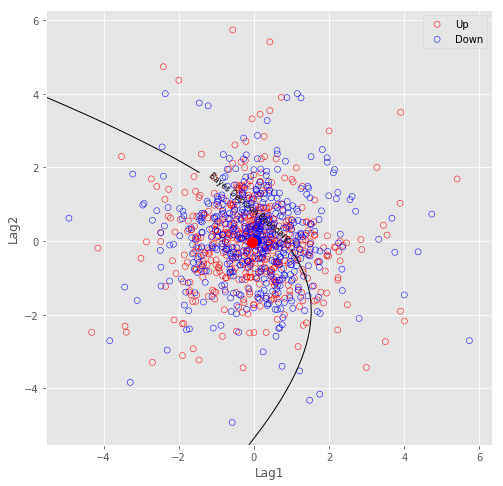

In [109]:
# Make a scatter plot of the lag predictors and show the Bayes decision boundary

# Scatter plot the data colored by market direction #
#####################################################
fig, ax = plt.subplots(figsize = (8, 8))

# Plot the training lags color coded by market direction
ax.scatter(X_train[Y_train == 1][:, 0], X_train[Y_train == 1][:, 1], facecolor = "None", edgecolor = "r", label = "Up")
ax.scatter(X_train[Y_train == 0][:, 0], X_train[Y_train == 0][:, 1], facecolor = "None", edgecolor = "b", label = "Down")

# Calculate Bayes Decision Boundary #
#####################################
# Construct a meshgrid to calulate Bayes Boundary over
nx, ny = 200, 200
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))

# Use predict_proba to calculate Probability at each x1,x2 pair
Z = qda_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

# The Bayes Boundary for k=2 classes is the contour where P(Y=k|X=x) = 0.5
cp = ax.contour(xx, yy, Z, [0.5], linewidths=1., colors='k');
plt.clabel(cp, inline=True, fmt='Bayes Decision Boundary',fontsize=8)

# Plot mean lag vector (lag1,lag2) for each class 'Up' and 'Down' #
###################################################################
ax.plot(qda_model.means_[0][0], qda_model.means_[0][1], 'o', color='blue', markersize=10);
ax.plot(qda_model.means_[1][0], qda_model.means_[1][1], 'o', color='red', markersize=10);

ax.set_xlabel('Lag1')
ax.set_ylabel('Lag2')
ax.legend(loc='best');

In [110]:
# Get the models predictions for market directions on the test set
Y_predict = qda_model.predict_proba(test_df[predictors].values)[:, 1]
Y_predict = np.array(Y_predict > 0.5, dtype=float)
# get the actual market directions from the testing dataframe
Y_test = np.array([1 if el=='Up' else 0 for el in test_df.Direction.values])

# Compute Test Confusion Matrix #
#################################
table = np.histogram2d(Y_predict, Y_test , bins=2)[0]
print(pd.DataFrame(table, ['Down', 'Up'], ['Down', 'Up']))
# same results as using the logistic function

      Down     Up
Down  30.0   20.0
Up    81.0  121.0


## 4.6.5 K-Nearest Neighbors

In [112]:
# Build a KNN classifier 
training_labels = training_df["Direction"].values

knn_1 = KNeighborsClassifier(n_neighbors= 1)
knn_1.fit(X_train, training_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

The Minkowski metric with p=2 is just the standard Euclidean distance metric.

In [114]:
# Make predictions using the model on the test set the predictors are still lag1 and lag2
# Get the models predictions for market directions on the test set
predicted_labels = knn_1.predict(test_df[predictors])

# get the actual market directions from the testing dataframe
testing_labels = test_df["Direction"].values

# Compute Test Confusion Matrix #
#################################
predicted_values = np.array([1 if el=='Up' else 0 for el in predicted_labels])
testing_values = np.array([1 if el=='Up' else 0 for el in testing_labels])

table = np.histogram2d(predicted_values, testing_values , bins=2)[0]
print(pd.DataFrame(table, ['Down', 'Up'], ['Down', 'Up']))
print('')
print('The model makes {0:.4f} correct predictions'.format(100*np.mean(predicted_values==testing_values)))


      Down    Up
Down  43.0  58.0
Up    68.0  83.0

The model makes 50.0000 correct predictions


In [115]:
# Build a KNN classifier 
training_labels = training_df["Direction"].values

knn_1 = KNeighborsClassifier(n_neighbors= 3)
knn_1.fit(X_train, training_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [116]:
# Make predictions using the model on the test set the predictors are still lag1 and lag2
# Get the models predictions for market directions on the test set
predicted_labels = knn_1.predict(test_df[predictors])

# get the actual market directions from the testing dataframe
testing_labels = test_df["Direction"].values

# Compute Test Confusion Matrix #
#################################
predicted_values = np.array([1 if el=='Up' else 0 for el in predicted_labels])
testing_values = np.array([1 if el=='Up' else 0 for el in testing_labels])

table = np.histogram2d(predicted_values, testing_values , bins=2)[0]
print(pd.DataFrame(table, ['Down', 'Up'], ['Down', 'Up']))
print('')
print('The model makes {0:.4f} correct predictions'.format(100*np.mean(predicted_values==testing_values)))


      Down    Up
Down  48.0  55.0
Up    63.0  86.0

The model makes 53.1746 correct predictions


## 4.6.6 K-Nearest Neighbors Applied to Caravan Insurance Data

In [117]:
# get dim of caravan data. There are 85 predictors involving various demograpic characteristics for 5822 individuals.
caravan_df.shape

(5822, 86)

In [118]:
# This last column is describes whether the individual purchased insurance 
print(caravan_df.columns[-1])
print(caravan_df.Purchase[:3])
caravan_df.Purchase.describe()

Purchase
1    No
2    No
3    No
Name: Purchase, dtype: object


count     5822
unique       2
top         No
freq      5474
Name: Purchase, dtype: object

In [119]:
print('The probability an individual purchased car insurance was,',
      1- caravan_df.Purchase.describe().freq / len(caravan_df.Purchase))

The probability an individual purchased car insurance was, 0.05977327378907593


In [120]:
np.random.seed(0)
# Standardize the Variables #
#############################
X = scale(caravan_df.iloc[:,0:85].values, axis=0)

# check that X[:,1] is now standardized
#print('mean =', np.mean(X[:,0]), 'variance = ', np.var(X[:,0]))

# Split the Data #
##################
# Get the response variable coding 0's and 1's
Y = np.array([1 if el=='Yes' else 0 for el in caravan_df.Purchase.values])

# Choose a random subset of the data, note the text does not randomly choose but it is a good idea
# number of training points
num_train_points = 1000

points = np.random.choice([False,True],size=len(X), p=[1-num_train_points/len(X) ,num_train_points/len(X)])

# Split the data into training and testing sets and get the responses
X_train = X[~points]
X_test = X[points]

# Build a k=1 neighbor classifier from the training data #
##########################################################
num_neighbors = 1
knn = KNeighborsClassifier(n_neighbors=num_neighbors)
Y_train = Y[~points]
knn.fit(X_train, Y_train)

# Make Label Predictions on the Test Data #
###########################################
predicted_labels = knn.predict(X_test)
actual_labels = Y[points]
# get the error rate
error_rate = np.mean(predicted_labels != actual_labels)
print('The error rate for k={0:d} is {1:.3f} %'.format(num_neighbors, 100*error_rate))
# Note that the number of people who bought car insurance was just under 6% so if we always predicted no we would 
# get an error rate of 6%

# Make a confusion matrix #
###########################
table = np.histogram2d(predicted_labels, actual_labels , bins=2)[0]
print(pd.DataFrame(table, ['No', 'Yes'], ['No', 'Yes']))
print('')
print('There were {0:.0f} customers predicted to buy insurance. The actual number who purchased was {1:.0f}. This gives {2:.3f} %'.format(table[1,0]+table[1,1], table[1,1], 100*table[1,1]/(table[1,0]+table[1,1])))


C:\DS_Softwares\anaconda3\envs\tensorflowcpu\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


The error rate for k=1 is 11.345 %
        No   Yes
No   876.0  47.0
Yes   66.0   7.0

There were 73 customers predicted to buy insurance. The actual number who purchased was 7. This gives 9.589 %


In [121]:
# Build a k=3 Neighbor Classifier #
###################################
num_neighbors = 3
knn = KNeighborsClassifier(n_neighbors=num_neighbors)
Y_train = Y[~points]
knn.fit(X_train, Y_train)

# Make Label Predictions on the Test Data #
###########################################
predicted_labels = knn.predict(X_test)
actual_labels = Y[points]

# Make a confusion matrix #
###########################
table = np.histogram2d(predicted_labels, actual_labels , bins=2)[0]
print(pd.DataFrame(table, ['No', 'Yes'], ['No', 'Yes']))
print('')
print('There were {0:.0f} customers predicted to buy insurance. The actual number who purchased was {1:.0f}. This gives {2:.3f} %'.format(table[1,0]+table[1,1], table[1,1], 100*table[1,1]/(table[1,0]+table[1,1])))


        No   Yes
No   924.0  51.0
Yes   18.0   3.0

There were 21 customers predicted to buy insurance. The actual number who purchased was 3. This gives 14.286 %


In [122]:
# Build a k=5 Neighbor Classifier #
###################################
num_neighbors = 5
knn = KNeighborsClassifier(n_neighbors=num_neighbors)
Y_train = Y[~points]
knn.fit(X_train, Y_train)

# Make Label Predictions on the Test Data #
###########################################
predicted_labels = knn.predict(X_test)
actual_labels = Y[points]

# Make a confusion matrix #
###########################
table = np.histogram2d(predicted_labels, actual_labels , bins=2)[0]
print(pd.DataFrame(table, ['No', 'Yes'], ['No', 'Yes']))
print('')
print('There were {0:.0f} customers predicted to buy insurance. The actual number who purchased was {1:.0f}. This gives {2:.3f} %'.format(table[1,0]+table[1,1], table[1,1], 100*table[1,1]/(table[1,0]+table[1,1])))


        No   Yes
No   936.0  51.0
Yes    6.0   3.0

There were 9 customers predicted to buy insurance. The actual number who purchased was 3. This gives 33.333 %
